In [2]:
import os, sys, time
import glob, re
import argparse

import pandas as pd
import numpy as np


In [3]:
from bs4 import BeautifulSoup
import nltk

#Download once if using NLTK for preprocessing
#nltk.download('punkt')

#Libraries for preprocessing
#from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
#from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans


In [4]:
# Visualization

from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px


In [5]:
#!pip install plotly

In [6]:
dirPath = os.getcwd()
dataDirectory = dirPath + "\data_html"
dataDirectory_err = dirPath + "\data_html_err"
resultDirectory = dirPath + "\\result"
print(resultDirectory)
print(dataDirectory)
print(dataDirectory_err)

C:\Users\ashur\NLP\result
C:\Users\ashur\NLP\data_html
C:\Users\ashur\NLP\data_html_err


In [7]:
lstFileNames = []
lstFileContentsInitial = []
files = glob.glob(os.path.join(dataDirectory, "*.html"))
for file in files:    
    # adding error handling
    try:
        with open(file, 'r') as f:
            # read the file as a string
            print("reading file: " + file)
            contents = f.read()
            print("read: " + str(len(contents)))
            lstFileContentsInitial.append(contents)  
        lstFileNames.append( os.path.basename(file))
    except:
        print("error reading file-*********" + os.path.basename(file))
        pass

reading file: C:\Users\ashur\NLP\data_html\beigebook199610.html
read: 16049
reading file: C:\Users\ashur\NLP\data_html\beigebook199612.html
read: 14650
reading file: C:\Users\ashur\NLP\data_html\beigebook199701.html
read: 13206
reading file: C:\Users\ashur\NLP\data_html\beigebook199703.html
read: 14489
reading file: C:\Users\ashur\NLP\data_html\beigebook199705.html
read: 15439
reading file: C:\Users\ashur\NLP\data_html\beigebook199706.html
read: 16991
reading file: C:\Users\ashur\NLP\data_html\beigebook199708.html
read: 15259
reading file: C:\Users\ashur\NLP\data_html\beigebook199709.html
read: 15143
reading file: C:\Users\ashur\NLP\data_html\beigebook199710.html
read: 13202
reading file: C:\Users\ashur\NLP\data_html\beigebook199712.html
read: 13541
reading file: C:\Users\ashur\NLP\data_html\beigebook199801.html
read: 14786
reading file: C:\Users\ashur\NLP\data_html\beigebook199803.html
read: 16358
reading file: C:\Users\ashur\NLP\data_html\beigebook199805.html
read: 13439
reading file

read: 19177
reading file: C:\Users\ashur\NLP\data_html\beigebook201012.html
read: 17740
reading file: C:\Users\ashur\NLP\data_html\beigebook201101.html
read: 157593
reading file: C:\Users\ashur\NLP\data_html\beigebook201103.html
read: 161720
reading file: C:\Users\ashur\NLP\data_html\beigebook201104.html
read: 162087
reading file: C:\Users\ashur\NLP\data_html\beigebook201106.html
read: 164206
reading file: C:\Users\ashur\NLP\data_html\beigebook201107.html
read: 160234
reading file: C:\Users\ashur\NLP\data_html\beigebook201109.html
read: 163738
reading file: C:\Users\ashur\NLP\data_html\beigebook201110.html
read: 157896
reading file: C:\Users\ashur\NLP\data_html\beigebook201111.html
read: 155771
reading file: C:\Users\ashur\NLP\data_html\beigebook201201.html
read: 158211
reading file: C:\Users\ashur\NLP\data_html\beigebook201202.html
read: 160223
reading file: C:\Users\ashur\NLP\data_html\beigebook201204.html
read: 157249
reading file: C:\Users\ashur\NLP\data_html\beigebook201206.html
r

In [8]:
files = glob.glob(os.path.join(dataDirectory_err, "*.html"))
for file in files:    
    # adding error handling
    try:
        with open(file, 'r',encoding = 'utf-8') as f:
            # read the file as a string
            print("reading file: " + file)
            contents = f.read()
            print("read: " + str(len(contents)))
            lstFileContentsInitial.append(contents)  
        lstFileNames.append( os.path.basename(file))
    except:
        print("error reading file-*********" + os.path.basename(file))
        pass

reading file: C:\Users\ashur\NLP\data_html_err\beigebook201903.html
read: 154490
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202003.html
read: 158024
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202010.html
read: 163160
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202101.html
read: 160664
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202103.html
read: 163640
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202104.html
read: 162271
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202106.html
read: 163575
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202107.html
read: 161779
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202109.html
read: 160873
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202110.html
read: 160082
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202112.html
read: 160842
reading file: C:\Users\ashur\NLP\data_html_err\beigebook202201.html
read: 188039
reading file: C:\Users\ashur

In [9]:
len(lstFileNames)

203

In [10]:
lstFileContents = []
for text in lstFileContentsInitial:
    #strips html formatting and converts to unicode
    cleanText = BeautifulSoup(text, 'html.parser').getText()
    lstFileContents.append(cleanText)

In [11]:
# generates index for each item in the corpora (in this case it's just rank) 
# and will be used for scoring later
fileIndex = []

for i in range(0,len(lstFileContents)):
    fileIndex.append(i)
len(fileIndex)

203

In [12]:
#!conda install -c conda-forge wordcloud

# WordCloud

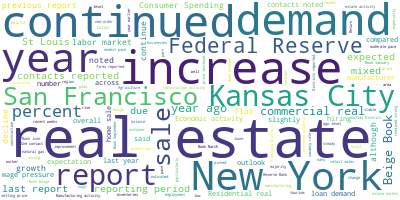

In [13]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(lstFileContents)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=12000000, contour_width=10, 
                      contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [18]:
wordcloud.words_

{'real estate': 1.0,
 'increase': 0.6857537611298741,
 'demand': 0.6301811482959779,
 'continued': 0.6277249002149217,
 'year': 0.5563401903592263,
 'New York': 0.539607000307031,
 'Kansas City': 0.47666564322996624,
 'report': 0.4694504144918637,
 'San Francisco': 0.4462695732268959,
 'sale': 0.4398219220141234,
 'Federal Reserve': 0.41894381332514585,
 'percent': 0.394688363524716,
 'commercial real': 0.39131102241326376,
 'year ago': 0.3831747006447651,
 'Beige Book': 0.3695118206938901,
 'contacts reported': 0.36352471599631564,
 'St Louis': 0.36014737488486337,
 'expected': 0.3366595026097636,
 'reporting period': 0.3343567700337734,
 'mixed': 0.33343567700337734,
 'last report': 0.3140927233650599,
 'due': 0.3085661651826834,
 'Consumer Spending': 0.30288609149524104,
 'growth': 0.2832361068467915,
 'decline': 0.2780165796745471,
 'flat': 0.26327909118821,
 'although': 0.2526865213386552,
 'noted': 0.24669941664108075,
 'continue': 0.24654590113601474,
 'labor market': 0.24608535

# Stopwords, stemming and tokenization

In [14]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [20]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [16]:
# add FRB cities as stopwords. Review clusters and add city names
more_stop_words = ['New York','Kansas City','San Francisco','Boston']
for w in more_stop_words:
    x = stemmer.stem(w)
    stopwords.append(x)

In [17]:
# add months as stop words. Review clusters and add months or other redundant information
more_stop_words = ['January','February','October']
for w in more_stop_words:
    x = stemmer.stem(w)
    stopwords.append(x)

In [18]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
# define a tokenizer and stemmer which returns the set of stems in the text 
#                                                         that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is 
    # caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) 
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, 
    #                                                     raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [20]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is 
    # caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) 
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, 
    #                                                        raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [21]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for text in lstFileContents:
    allwords_stemmed = tokenize_and_stem(text)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized.extend(allwords_tokenized)

In [22]:
totalvocab_tokenized

['frb',
 'beige',
 'book',
 'summary',
 'october',
 'summary',
 'skip',
 'to',
 'content',
 'summary',
 'districts',
 'boston',
 'new',
 'york',
 'philadelphia',
 'cleveland',
 'richmond',
 'atlanta',
 'chicago',
 'st.',
 'louis',
 'minneapolis',
 'kansas',
 'city',
 'dallas',
 'san',
 'francisco',
 'full',
 'report',
 'prepared',
 'at',
 'the',
 'federal',
 'reserve',
 'bank',
 'of',
 'minneapolis',
 'based',
 'on',
 'information',
 'collected',
 'before',
 'october',
 'this',
 'document',
 'summarizes',
 'comments',
 'received',
 'from',
 'businesses',
 'and',
 'other',
 'contacts',
 'outside',
 'the',
 'federal',
 'reserve',
 'and',
 'is',
 'not',
 'a',
 'commentary',
 'on',
 'the',
 'views',
 'of',
 'federal',
 'reserve',
 'officials',
 'moderate',
 'expansion',
 'of',
 'business',
 'activity',
 'characterizes',
 'the',
 'economy',
 'in',
 'most',
 'federal',
 'reserve',
 'districts',
 'but',
 'on',
 'balance',
 'the',
 'pace',
 'of',
 'growth',
 'reportedly',
 'has',
 'slowed',
 '

In [29]:
totalvocab_stemmed

['frb',
 'beig',
 'book',
 'summari',
 'octob',
 'summari',
 'skip',
 'to',
 'content',
 'summari',
 'district',
 'boston',
 'new',
 'york',
 'philadelphia',
 'cleveland',
 'richmond',
 'atlanta',
 'chicago',
 'st.',
 'loui',
 'minneapoli',
 'kansa',
 'citi',
 'dalla',
 'san',
 'francisco',
 'full',
 'report',
 'prepar',
 'at',
 'the',
 'feder',
 'reserv',
 'bank',
 'of',
 'minneapoli',
 'base',
 'on',
 'inform',
 'collect',
 'befor',
 'octob',
 'this',
 'document',
 'summar',
 'comment',
 'receiv',
 'from',
 'busi',
 'and',
 'other',
 'contact',
 'outsid',
 'the',
 'feder',
 'reserv',
 'and',
 'is',
 'not',
 'a',
 'commentari',
 'on',
 'the',
 'view',
 'of',
 'feder',
 'reserv',
 'offici',
 'moder',
 'expans',
 'of',
 'busi',
 'activ',
 'character',
 'the',
 'economi',
 'in',
 'most',
 'feder',
 'reserv',
 'district',
 'but',
 'on',
 'balanc',
 'the',
 'pace',
 'of',
 'growth',
 'report',
 'has',
 'slow',
 'somewhat',
 'slower',
 'growth',
 'is',
 'report',
 'in',
 'the',
 'southwest'

In [23]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, 
                                  index = totalvocab_stemmed)

In [31]:
vocab_frame

words
frb                  frb
beig               beige
book                book
summari          summary
octob            october
...                  ...
constitut   constitution
avenu             avenue
n.w.                n.w.
washington    washington
dc                    dc

[1763294 rows x 1 columns]

# Vectorization using TF-IDF

In [24]:
# Make a note of the warning. 179 stopwords is a fairly small list of stopwords.

from sklearn.feature_extraction.text import TfidfVectorizer
# turn our cleaned text into numerical data so that we can perform 
#                                          statistical analysis on it.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                min_df=0.2, stop_words=stopwords,
                use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(lstFileContents)

C:\Users\ashur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'c', 'could', 'doe', 'dure', 'francisco', 'kansa', 'might', 'must', "n't", 'need', 'new', 'onc', 'onli', 'ourselv', 'san', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'york', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


# Distance Measurement

In [25]:
tfidf_matrix.shape

(203, 6828)

In [34]:
print(tfidf_matrix[0])

  (0, 2663)	0.03759304850214397
  (0, 2478)	0.03759304850214397
  (0, 2497)	0.03759304850214397
  (0, 4695)	0.03759304850214397
  (0, 5972)	0.03759304850214397
  (0, 1269)	0.03759304850214397
  (0, 229)	0.03759304850214397
  (0, 1072)	0.03759304850214397
  (0, 4707)	0.02492117248970446
  (0, 4013)	0.02492117248970446
  (0, 6450)	0.02492117248970446
  (0, 5527)	0.02492117248970446
  (0, 4819)	0.03728714112737138
  (0, 4811)	0.037905013840764556
  (0, 5260)	0.03669259000934411
  (0, 3461)	0.03260431945996322
  (0, 5029)	0.05764239964330873
  (0, 2569)	0.03728714112737138
  (0, 4165)	0.02359654936063504
  (0, 1701)	0.02973207400725849
  (0, 3422)	0.025627736414371074
  (0, 4182)	0.02682860211262992
  (0, 5269)	0.07113368888443182
  (0, 3130)	0.04028103764629575
  (0, 2565)	0.03640352254509282
  :	:
  (0, 1399)	0.05243345935835393
  (0, 978)	0.04028103764629575
  (0, 768)	0.03283099581378385
  (0, 6738)	0.04270129729768572
  (0, 6595)	0.10091585654758113
  (0, 5027)	0.1349563413696471
  (0

In [35]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00479663, 0.00491434, 0.        , ..., 0.00526573, 0.00526573,
         0.00526573],
        [0.00493303, 0.00505409, 0.        , ..., 0.00541547, 0.00541547,
         0.00541547],
        [0.00974745, 0.00998665, 0.        , ..., 0.00535036, 0.00535036,
         0.00535036]])

In [26]:
tfidf_matrix.todense().shape

(203, 6828)

In [37]:
print(tfidf_matrix[200,:].toarray())

[[0.00479663 0.00491434 0.         ... 0.00526573 0.00526573 0.00526573]]


In [38]:
tfidf_matrix[200,:].toarray().shape

(1, 6828)

# Cosine Similarity

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [40]:
dist.shape

(203, 203)

In [41]:
type(dist)

numpy.ndarray

In [42]:
df=pd.DataFrame(dist)

In [43]:
# Plot the matrix in excel and it can show you a break in document 
#                  structure in addition to similarity in documents.
df.to_excel('C:\Data\BigData_BC\Lectures\FinalProject\cosine_v2.xlsx')

In [ ]:
#import seaborn as sn
#import matplotlib.pyplot as plt
#sn.heatmap(dist, annot=True)
#plt.show()

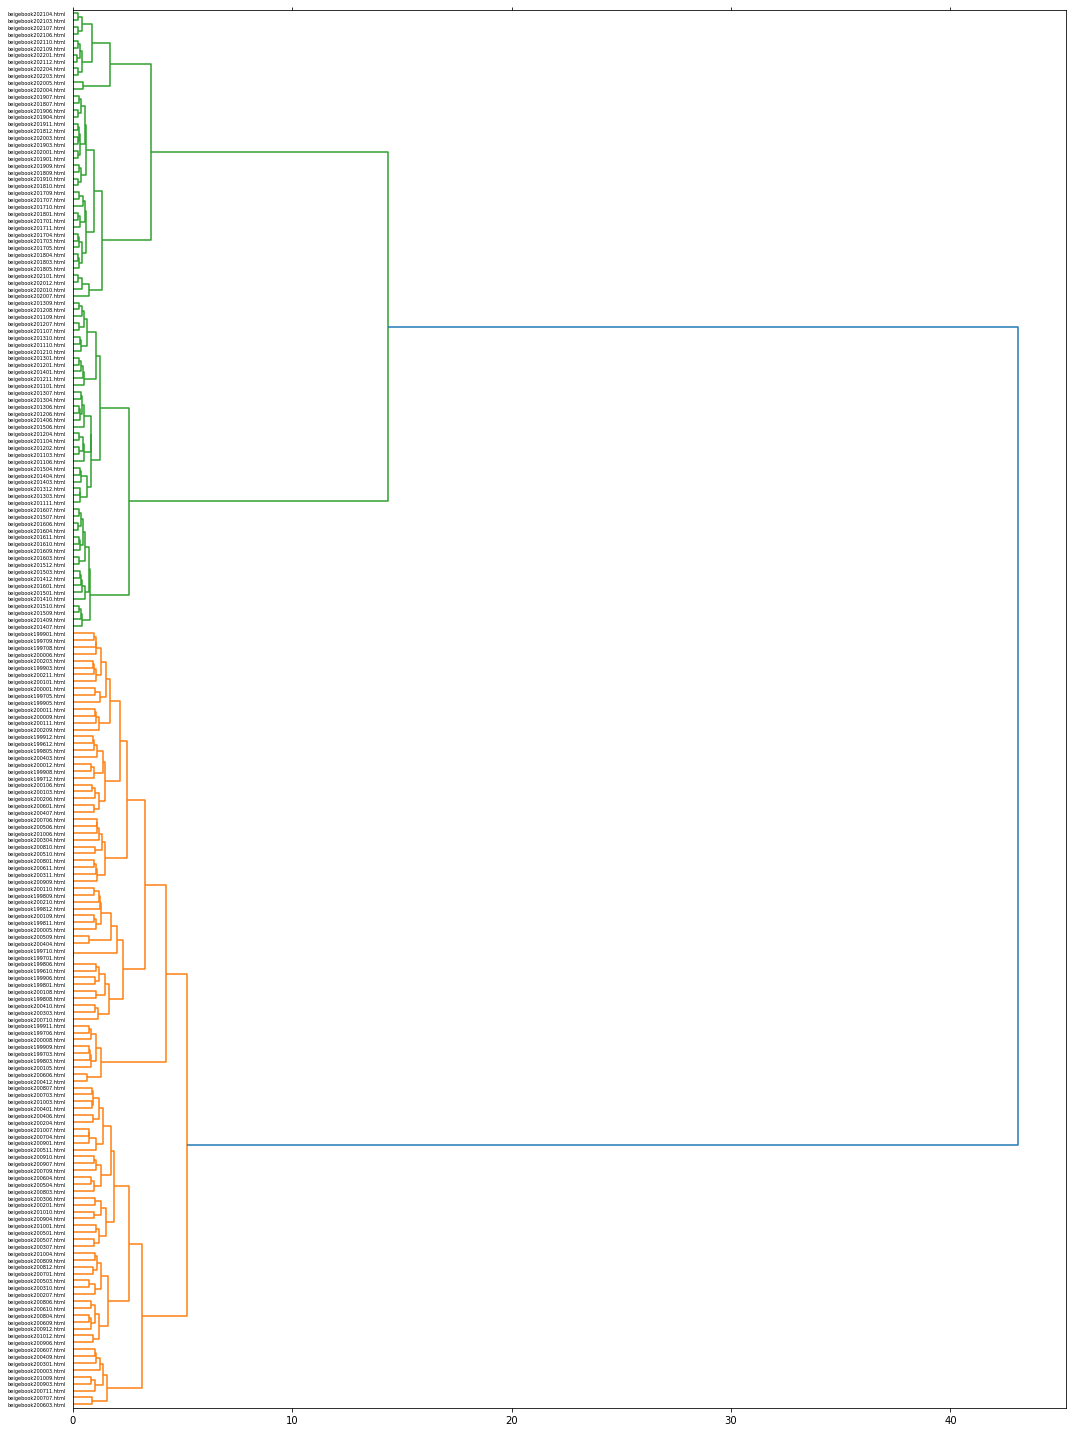

In [28]:
# Document level analysis
%matplotlib inline
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=lstFileNames);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# K-means clustering

In [29]:
# Take all the documents and cluster the documents by num_clusters by its content 
#                                                         (6,785 words and frequencies)

from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

#%time km.fit(tfidf_matrix)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [47]:
clusters

[2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 4,
 2,
 2,
 2,
 2,
 4,
 4,
 2,
 2,
 0,
 4,
 4,
 4,
 4,
 2,
 0,
 4,
 2,
 2,
 2,
 0,
 0,
 4,
 2,
 4,
 4,
 0,
 4,
 4,
 4,
 2,
 2,
 0,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

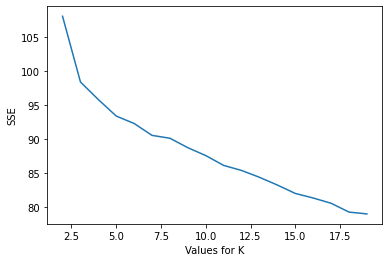

In [48]:
# When the curve flattens out, it signifies optimal number of clusters
sse={}
#for k in np.arange(2,20,1):
for k in np.arange(2,20,1): # categorize the document. Hawkish/dovish could just be 2.
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tfidf_matrix)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [30]:
BeigeBooks = { 'fileNames': lstFileNames, 'fileIndex': fileIndex, 
             'contents': lstFileContents, 'cluster':   clusters, 
                                          'sections':  lstFileNames }

dfBeigeBooks = pd.DataFrame(BeigeBooks, index = [clusters] , 
                columns = ['fileIndex', 'fileNames', 'cluster', 'sections'])

In [50]:
dfBeigeBooks.describe()

fileIndex     cluster
count  203.000000  203.000000
mean   101.000000    2.334975
std     58.745213    1.241250
min      0.000000    0.000000
25%     50.500000    1.000000
50%    101.000000    2.000000
75%    151.500000    3.000000
max    202.000000    4.000000

In [31]:
terms = tfidf_vectorizer.get_feature_names()

In [32]:
terms

["'s busi",
 "'s busi inflat",
 "'s co-op",
 "'s co-op condo",
 "'s economi",
 "'s key",
 "'s key polici",
 "'s level",
 "'s new",
 "'s new 's",
 "'s next",
 "'s next site",
 "'s servic",
 "'s servic sector",
 '16,1998beig',
 '16,1998beig book',
 '16,1998beig book august',
 '1996beig',
 '1996beig book',
 '1996beig book home',
 '1997beig',
 '1997beig book',
 '1997beig book 1997beig',
 '1997beig book 22,1997beig',
 '1997beig book august',
 '1997beig book june',
 '1997beig book march',
 '1997beig book may',
 '1997beig book septemb',
 '1998beig',
 '1998beig book',
 '1998beig book 1998beig',
 '1998beig book decemb',
 '1998beig book june',
 '1998beig book march',
 '1998beig book may',
 '1998beig book novemb',
 '1998beig book septemb',
 '1999beig',
 '1999beig book',
 '1999beig book 1999beig',
 '1999beig book august',
 '1999beig book decemb',
 '1999beig book june',
 '1999beig book march',
 '1999beig book may',
 '1999beig book novemb',
 '1999beig book septemb',
 '2000beig',
 '2000beig book',
 '

In [53]:
num_clusters

5

In [33]:
from __future__ import print_function
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :100]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print()
    print()
    print("Cluster %d fileNames:" % i, end='')
    for fileName in dfBeigeBooks.loc[i]['fileNames'].tolist():
        print(' %s,' % fileName, end='')
        print()
    print()

Top terms per cluster:

Cluster 0 words: b'period',
 b'contacts',
 b'since',
 b'percent',
 b'previous',
 b'one',
 b'rose',
 b'surveys',
 b'report',
 b'previous',
 b'since',
 b'supply',
 b'contacts',
 b'due',
 b'grew',
 b'outlook',
 b'balance',
 b'positive',
 b'since',
 b'summary',
 b'summary',
 b'compared',
 b'shortage',
 b'firms',
 b'weeks',
 b'though',
 b'decrease',
 b'next',
 b'trades',
 b'data',
 b'volume',
 b'increases',
 b'contacts',
 b'selling',
 b'picked',
 b'conditions',
 b'information',
 b'information',
 b'economic',
 b'restaurant',
 b'respondents',
 b'major',
 b'districts',
 b'supply',
 b'quarter',
 b'districts',
 b'selling',
 b'during',
 b'saw',
 b'states',
 b'hospitality',
 b'chain',
 b'increases',
 b'employment',
 b'recent',
 b'robust',
 b'professionals',
 b'increases',
 b'uncertainty',
 b'leasing',
 b'modestly',
 b'since',
 b'staffing',
 b'among',
 b'moderate',
 b'regulations',
 b'last',
 b'linked',
 b'linked',
 b'economic',
 b'revenues',
 b'development',
 b'job',
 b'vis

 b'york',
 b'december',
 b'dallas',
 b'suggest',
 b'atlanta',
 b'philadelphia',
 b'philadelphia',
 b'minneapolis',
 b'francisco',
 b'san',
 b'according',
 b'city',
 b'philadelphia',
 b'march',
 b'wages',
 b'districts',
 b'still',
 b'districts',
 b'apparel',
 b'richmond',
 b'several',
 b'chicago',
 b'chicago',
 b'strengthen',
 b'minneapolis',
 b'minneapolis',
 b'chicago',
 b'chicago',
 b'last',
 b'last',
 b'since',
 b'plant',
 b'high',
 b'districts',
 b'significant',
 b'may',
 b'picked',
 b'city',
 b'many',
 b'ago',
 b'districts',
 b'across',
 b'competition',
 b'winter',
 b'region',
 b'soft',
 b'atlanta',
 b'louis',
 b'louis',
 b'st.',
 b'philadelphia',
 b'philadelphia',

Cluster 3 fileNames: beigebook199703.html,
 beigebook199705.html,
 beigebook199706.html,
 beigebook199803.html,
 beigebook199812.html,
 beigebook199905.html,
 beigebook199909.html,
 beigebook199911.html,
 beigebook200001.html,
 beigebook200008.html,
 beigebook200105.html,
 beigebook200201.html,
 beigebook200306.html,
 

# Topic Modeling

In [55]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [56]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [ ]:
#!conda install -c conda-forge gensim

In [57]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in lstFileContents]

#%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [58]:
texts

[['content',
  'report',
  'base',
  'inform',
  'collect',
  'befor',
  'document',
  'summar',
  'comment',
  'receiv',
  'busi',
  'contact',
  'outsid',
  'commentari',
  'view',
  'offici',
  'expans',
  'busi',
  'activ',
  'character',
  'economi',
  'district',
  'balanc',
  'pace',
  'growth',
  'report',
  'slow',
  'somewhat',
  'growth',
  'report',
  'along',
  'eastern',
  'seaboard',
  'except',
  'continu',
  'show',
  'moder',
  'strong',
  'growth',
  'two',
  'district',
  'lag',
  'much',
  'rest',
  'nation',
  'first',
  'half',
  '1990s',
  'indic',
  'improv',
  'perform',
  'indic',
  'signific',
  'price',
  'increas',
  'raw',
  'materi',
  'good',
  'servic',
  'report',
  'upward',
  'pressur',
  'wage',
  'widespread',
  'balanc',
  'consum',
  'spend',
  'best',
  'character',
  'moder',
  'sign',
  'strength',
  'area',
  'sale',
  'boom',
  'consider',
  'variat',
  'pattern',
  'spend',
  'region',
  'categori',
  'merchandis',
  'describ',
  'double-d

In [59]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [60]:
corpus[0][0:]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 4),
 (8, 1),
 (9, 4),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 4),
 (15, 3),
 (16, 2),
 (17, 3),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 3),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 3),
 (37, 1),
 (38, 1),
 (39, 4),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 2),
 (49, 1),
 (50, 1),
 (51, 2),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 3),
 (56, 2),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 2),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 3),
 (67, 1),
 (68, 1),
 (69, 2),
 (70, 1),
 (71, 1),
 (72, 19),
 (73, 1),
 (74, 1),
 (75, 2),
 (76, 1),
 (77, 2),
 (78, 2),
 (79, 1),
 (80, 3),
 (81, 1),
 (82, 1),
 (83, 3),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 2),
 (89, 2),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 2),
 (94, 2),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 3)

In [61]:
#%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [62]:
topics = lda_model.print_topics(5, num_words=20)
topics

[(0,
  '0.013*"percent" + 0.012*"sinc" + 0.008*"dure" + 0.007*"period" + 0.006*"posit" + 0.006*"due" + 0.006*"outlook" + 0.005*"decreas" + 0.005*"survey" + 0.005*"compar" + 0.005*"dealer" + 0.005*"cite" + 0.004*"ago" + 0.004*"week" + 0.004*"bank" + 0.004*"earli" + 0.004*"major" + 0.004*"rose" + 0.004*"volum" + 0.004*"previous"'),
 (1,
  '0.011*"suppli" + 0.008*"period" + 0.008*"sinc" + 0.008*"shortag" + 0.007*"due" + 0.007*"rose" + 0.007*"percent" + 0.006*"previous" + 0.006*"chain" + 0.006*"week" + 0.006*"disrupt" + 0.005*"though" + 0.005*"robust" + 0.004*"hospit" + 0.004*"decreas" + 0.004*"signific" + 0.004*"pandem" + 0.004*"saw" + 0.004*"among" + 0.004*"avail"'),
 (2,
  '0.016*"period" + 0.014*"sinc" + 0.012*"percent" + 0.011*"previous" + 0.008*"posit" + 0.007*"rose" + 0.006*"dure" + 0.006*"ago" + 0.006*"grew" + 0.006*"compar" + 0.005*"week" + 0.005*"decreas" + 0.005*"survey" + 0.005*"volum" + 0.005*"outlook" + 0.005*"cite" + 0.005*"one" + 0.005*"pick" + 0.005*"unchang" + 0.005*"earl

In [63]:
topics_matrix = lda_model.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

C:\Users\ashur\AppData\Local\Temp/ipykernel_1764/4199977372.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics_matrix = np.array(topics_matrix)


In [64]:
#topics_matrix[2][1][2][0]
for i in range(len(topics_matrix)):
    topic_words =''
    for j in range(len(topics_matrix[i][1])):
        topic_words = topic_words + topics_matrix[i][1][j][0] +  ' ' 
    print('Topic '  + str(i+1) + ': ' + topic_words)

Topic 1: percent sinc dure period posit due outlook decreas survey compar dealer cite ago week bank earli major rose volum previous 
Topic 2: suppli period sinc shortag due rose percent previous chain week disrupt though robust hospit decreas signific pandem saw among avail 
Topic 3: period sinc percent previous posit rose dure ago grew compar week decreas survey volum outlook cite one pick unchang earlier 
Topic 4: period previous sinc percent rose posit trade compar survey balanc grew due tariff transport sell major outlook saw decreas earlier 
Topic 5: district region shortag cite countri character strength soft suggest pickup onli though earli eas still hous appear skill sluggish calendar 


In [65]:
for i in range(len(topics_matrix)):
    for j in range(len(topics_matrix[i][1])):
        print(str(i+1) + ', ' + topics_matrix[i][1][j][0] + ', ' + str(topics_matrix[i][1][j][1]))

1, percent, 0.012874014
1, sinc, 0.01179018
1, dure, 0.008206826
1, period, 0.006873385
1, posit, 0.006189881
1, due, 0.00592899
1, outlook, 0.0058821137
1, decreas, 0.005111615
1, survey, 0.0049483753
1, compar, 0.0047639776
1, dealer, 0.004589032
1, cite, 0.0045340923
1, ago, 0.0043802382
1, week, 0.0043620267
1, bank, 0.0043521975
1, earli, 0.0043030195
1, major, 0.0042309333
1, rose, 0.004217484
1, volum, 0.004170653
1, previous, 0.003974851
2, suppli, 0.011216992
2, period, 0.008421227
2, sinc, 0.008335672
2, shortag, 0.008306077
2, due, 0.0074287322
2, rose, 0.0071571968
2, percent, 0.0070491787
2, previous, 0.0063759945
2, chain, 0.006310282
2, week, 0.005890821
2, disrupt, 0.0056562573
2, though, 0.005246475
2, robust, 0.0050857756
2, hospit, 0.004379179
2, decreas, 0.004376023
2, signific, 0.0042120214
2, pandem, 0.003983405
2, saw, 0.0038912601
2, among, 0.0038676658
2, avail, 0.0038649624
3, period, 0.016205275
3, sinc, 0.013548812
3, percent, 0.012226571
3, previous, 0.0112

In [66]:
filename = resultDirectory + '\\bb_lda_topics.txt'
f = open(filename, 'a')

for i in range(len(topics_matrix)):
    topic_words =''
    for j in range(len(topics_matrix[i][1])):
        topic_words = topic_words + topics_matrix[i][1][j][0] +  ' ' 
    print('Topic '  + str(i+1) + ': ' + topic_words)
    f.write('Topic '  + str(i+1) + ':, ' + topic_words)

Topic 1: percent sinc dure period posit due outlook decreas survey compar dealer cite ago week bank earli major rose volum previous 
Topic 2: suppli period sinc shortag due rose percent previous chain week disrupt though robust hospit decreas signific pandem saw among avail 
Topic 3: period sinc percent previous posit rose dure ago grew compar week decreas survey volum outlook cite one pick unchang earlier 
Topic 4: period previous sinc percent rose posit trade compar survey balanc grew due tariff transport sell major outlook saw decreas earlier 
Topic 5: district region shortag cite countri character strength soft suggest pickup onli though earli eas still hous appear skill sluggish calendar 


In [67]:
filename = resultDirectory + '\\bb_lda_topic_words.txt'
f = open(filename, 'a')

for i in range(len(topics_matrix)):
    for j in range(len(topics_matrix[i][1])):
        print(str(i+1) + ', ' + topics_matrix[i][1][j][0] + ', ' + str(topics_matrix[i][1][j][1]))
        f.write(str(i+1) + ', ' + topics_matrix[i][1][j][0] + ', ' + str(topics_matrix[i][1][j][1]))

f.close()

1, percent, 0.012874014
1, sinc, 0.01179018
1, dure, 0.008206826
1, period, 0.006873385
1, posit, 0.006189881
1, due, 0.00592899
1, outlook, 0.0058821137
1, decreas, 0.005111615
1, survey, 0.0049483753
1, compar, 0.0047639776
1, dealer, 0.004589032
1, cite, 0.0045340923
1, ago, 0.0043802382
1, week, 0.0043620267
1, bank, 0.0043521975
1, earli, 0.0043030195
1, major, 0.0042309333
1, rose, 0.004217484
1, volum, 0.004170653
1, previous, 0.003974851
2, suppli, 0.011216992
2, period, 0.008421227
2, sinc, 0.008335672
2, shortag, 0.008306077
2, due, 0.0074287322
2, rose, 0.0071571968
2, percent, 0.0070491787
2, previous, 0.0063759945
2, chain, 0.006310282
2, week, 0.005890821
2, disrupt, 0.0056562573
2, though, 0.005246475
2, robust, 0.0050857756
2, hospit, 0.004379179
2, decreas, 0.004376023
2, signific, 0.0042120214
2, pandem, 0.003983405
2, saw, 0.0038912601
2, among, 0.0038676658
2, avail, 0.0038649624
3, period, 0.016205275
3, sinc, 0.013548812
3, percent, 0.012226571
3, previous, 0.0112

In [68]:
#!pip install pyLDAvis

In [69]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import pickle 


# Visualize the topics
pyLDAvis.enable_notebook()

num_topics = 5
LDAvis_data_filepath = os.path.join('./result/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './result/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Users\ashur\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.024024 -0.034961       1        1  32.504185
0     -0.006407 -0.037926       2        1  26.852196
3     -0.049907  0.001999       3        1  17.569536
1     -0.047928  0.057185       4        1  16.424490
4      0.128266  0.013703       5        1   6.649593, topic_info=          Term         Freq        Total Category  logprob  loglift
72    district  1725.000000  1725.000000  Default  30.0000  30.0000
222    shortag  1577.000000  1577.000000  Default  29.0000  29.0000
2909    tariff   450.000000   450.000000  Default  28.0000  28.0000
631     period  4989.000000  4989.000000  Default  27.0000  27.0000
380     suppli  1919.000000  1919.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3       accord    99.791324   801.384190   Topic5  -5.6683   0.6274
93      expans    96.529503   749.993066   Topic5  -5.7015   0.6604
48    competit    99.129746   890.924614   Topic5  -5.6750   0.5148
209     robust   100.612612  1534.584634   Topic5  -5.6601  -0.0141
274     winter    94.167708   812.925578   Topic5  -5.7263   0.5551

[446 rows x 6 columns], token_table=      Topic      Freq                                Term
term                                                     
6112      3  0.778895  //research.stlouisfed.org/regecon/
6112      4  0.179745  //research.stlouisfed.org/regecon/
2656      2  0.885403                                 4th
5670      1  0.031931                             absente
5670      4  0.957924                             absente
...     ...       ...                                 ...
392       2  0.232218                      year-over-year
392       3  0.237437                      year-over-year
392       4  0.078276                      year-over-year
392       5  0.013916                      year-over-year
6274      3  0.815811                             yearâ€™

[1095 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])